In [1]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# # !pip install matplotlib
# # !pip install seaborn

# Data

In [2]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [3]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import datetime
from datetime import timedelta
import scipy.stats as st

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")

In [6]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [7]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list ={}

s3 = boto3.resource('s3')
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')

In [8]:
for obj in bucket.objects.filter(Prefix='input_percent_view'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    df = pd.read_csv(body, na_values = [np.NaN])
    df.columns = df.columns.str.lower()

    df = df.loc[:, df.isnull().sum()!=df.shape[0]]

    df = df.loc[df['match_id_platform'].\
    isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL'])==False,:]\
    .reset_index(drop = True)

    data_list[var_name] = df


Reading funnel_metric_feature features
Reading media_cost_postlaunch_feature features
Reading media_cost_prelaunch_feature features
Reading metadata_feature features
Reading prelaunch_trailer_feature features
Reading prelaunch_trailer_feature_before28 features
Reading sub_total_feature features
Reading trailer_feature features
Reading vtp_feature features
Reading wiki_view_feature_before28 features
Reading wiki_view_post_feature features
Reading wiki_view_pre_feature features


# Metadata

In [9]:
metadata_feature=data_list['metadata_feature']

In [10]:
popcorn_titles = run_query('''
SELECT * FROM MAX_PROD.CATALOG.POPCORN_TITLES
''')

In [14]:
## Total Active Base
daily_total_views = run_query('''
select *
from max_dev.workspace.latam_metrics_base
order by start_date, end_date
''')

In [15]:
daily_total_views.head()

,start_date,end_date,days_on_hbo_max,actives_base,total_hours_viewed_base,record_count_base,first_viewing_accounts_base
0,2021-06-29,2021-06-30,1,757520,1601376,3508654,713107
1,2021-06-29,2021-07-01,2,1250852,4281569,9536864,1182698
2,2021-06-29,2021-07-02,3,1576503,7301637,16432734,1492066
3,2021-06-29,2021-07-03,4,1817397,10412464,23444867,1720234
4,2021-06-29,2021-07-04,5,2070381,14307409,31564101,1960750


In [16]:
# Daily Actives by title
title_actives = run_query('''
select *
from MAX_DEV.WORKSPACE.latam_title_level_metrics
order by title_name, available_date, end_date
''')

In [17]:
title_actives.head()

,title_name,match_id,content_category,available_date,days_on_hbo_max,end_date,actives,total_hours_viewed,record_count,count_first_viewing_accounts
0,#Pobre novio,GYSAr8wiBN8IqpAEAAAAE-1,Series,2021-08-23,1,2021-08-24,4665,5620,11092,75
1,#Pobre novio,GYSAr8wiBN8IqpAEAAAAE-1,Series,2021-08-23,2,2021-08-25,9674,14657,29516,162
2,#Pobre novio,GYSAr8wiBN8IqpAEAAAAE-1,Series,2021-08-23,3,2021-08-26,12318,21476,43719,209
3,#Pobre novio,GYSAr8wiBN8IqpAEAAAAE-1,Series,2021-08-23,4,2021-08-27,14094,26522,54308,250
4,#Pobre novio,GYSAr8wiBN8IqpAEAAAAE-1,Series,2021-08-23,5,2021-08-28,16042,31403,64307,300


In [13]:
title_actives.drop_duplicates(inplace = True)

In [14]:
pct_actives = pd.merge(title_actives[['match_id', 'title_name', 'days_on_hbo_max', 'available_date', 'actives']], 
                      daily_total_views[['start_date', 'end_date', 'actives_base', 'days_on_hbo_max']],
                      left_on = ['available_date', 'days_on_hbo_max'], right_on = ['start_date', 'days_on_hbo_max'],
                      how = 'inner')

In [15]:
pct_actives['pct_actives'] = pct_actives['actives']/pct_actives['actives_base']*100

In [16]:
metadata_feature = metadata_feature.groupby(['match_id']).first().reset_index()

In [17]:
pct_actives['match_id'] = pct_actives['match_id'].astype(str)
metadata_feature['match_id'] = metadata_feature['match_id'].astype(str)

In [18]:
pct_actives=pd.merge(pct_actives,
                      metadata_feature.rename(columns = {'title_name':'id'}), 
                      on = ['match_id'],how = 'left')

In [19]:
recent_originals = pct_actives[(pct_actives['program_type'] == 'original')
                         &(pct_actives['prod_release_year'] >= 2021)
                         &(pct_actives['platform_name'] == 1)
                         ].copy()

popcorn_titles = pd.merge(pct_actives,  popcorn_titles[['viewable_id']],
                         left_on = ['match_id'], right_on = ['viewable_id']).copy()

In [20]:
recent_originals['originals_after_launch'] = 1
popcorn_titles['popcorn_titles'] = 1

In [21]:
recent_originals.drop_duplicates(inplace = True)

In [22]:
popcorn_titles.drop_duplicates(inplace = True)

In [23]:
pct_actives = pd.merge(pct_actives, recent_originals[['match_id', 'originals_after_launch', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'days_on_hbo_max', 'available_date'], how = 'left')


In [24]:
pct_actives = pd.merge(pct_actives, popcorn_titles[['match_id', 'popcorn_titles', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'available_date', 'days_on_hbo_max'], how = 'left')

In [25]:
pct_actives.loc[pct_actives['originals_after_launch'] == 1, 'originals_type'] = 'originals_after_launch'
pct_actives.loc[pct_actives['popcorn_titles'] == 1, 'originals_type'] = 'popcorn_titles'
pct_actives['originals_type'] = pct_actives['originals_type'].fillna(pct_actives['program_type'])
pct_actives = pct_actives.drop(['originals_after_launch', 'popcorn_titles'], axis = 1)

In [26]:
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))

In [27]:
popcorn_titles.title_name.unique()

array(['Wonder Woman 1984', 'Space Jam: A New Legacy', 'Tom & Jerry',
       'Mortal Kombat', 'Those Who Wish Me Dead',
       'The Many Saints of Newark', 'Malignant', 'Cry Macho', 'Dune',
       'Reminiscence', 'Godzilla vs. Kong', 'The Little Things',
       'In the Heights', 'Judas and the Black Messiah',
       'The Suicide Squad'], dtype=object)

## write to S3

In [147]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [148]:
input_bucket = 'hbo-ingest-datascience-content-dev'

In [149]:
csv_buffer = io.StringIO()
pct_actives.to_csv(csv_buffer, index = False)
content = csv_buffer.getvalue()

filename = 'pct_actives_prediction/pct_actives.csv'

to_s3(filename, input_bucket, content)

# MODEL

In [28]:
META_COLUMNS = ['match_id',
                'title_name',
                'available_date',
                'originals_type',
                'content_category',
                'real_date',
                'prediction_start_day',
                ]
TRACKING_COLUMN = {'pct_actives': 'pct_actives',
                 'total_actives': 'total_viewing_accounts',
                 'title_actives': 'title_viewing_accounts',
                 }

In [29]:
class DecayModel:
    def __init__(self, kpi):
        self.tracking_col = TRACKING_COLUMN[kpi]
        self.multiplier_df = None
        
    def fit(self, train_df):
        pct_actives = train_df
        pct_actives_from = pct_actives[['originals_type', 'content_category',
                                    'match_id','prediction_start_day', self.tracking_col]]
        pct_actives_from.rename(columns={self.tracking_col: self.tracking_col + '_from'}, inplace=True)


        pct_actives_to = pct_actives[['originals_type', 'content_category',
                                        'match_id','prediction_start_day', self.tracking_col]]
        pct_actives_to.rename(columns={self.tracking_col: self.tracking_col + '_to',
                                         'prediction_start_day': 'days_after_launch'}, inplace=True)


        multipliers = pd.merge(pct_actives_from, pct_actives_to,
                           on=['originals_type', 'content_category',
                               'match_id'])
        multipliers['multiplier'] = multipliers[self.tracking_col + '_to'] / multipliers[self.tracking_col+ '_from']
        multiplier_df = multipliers.groupby(['originals_type', 'content_category',
                                             'prediction_start_day', 'days_after_launch'],
                                            as_index=False).agg({'multiplier': 'median'})
        self.multiplier_df = multiplier_df
        
    def predict(self, pred_df):
                
        postlaunch_df = pred_df[META_COLUMNS + [self.tracking_col]]
        
        assert self.tracking_col in postlaunch_df.columns


        postlaunch_df = pd.merge(postlaunch_df, self.multiplier_df,
                                 on=['originals_type', 'content_category', 'prediction_start_day'],
                                 how='left')
        
        postlaunch_prediction = np.where(postlaunch_df['prediction_start_day'] > postlaunch_df['days_after_launch'],
                                         np.nan,
                                         postlaunch_df[self.tracking_col] * postlaunch_df['multiplier'])

        postlaunch_df['prediction'] = postlaunch_prediction
        
        
        postlaunch_df = postlaunch_df[META_COLUMNS + ['days_after_launch', 'prediction']]
        
        return postlaunch_df

# Cross Validation

In [111]:
kpi = 'pct_actives'

data_train_all = pct_actives.copy()

data_train_all.rename(columns={"days_on_hbo_max": "prediction_start_day"}, inplace=True)
data_train_all['real_date'] = data_train_all['real_date'].map(str).map(lambda x: x[:10])
data_train_all['available_date'] = data_train_all['available_date'].map(str).map(lambda x: x[:10])

# logger.info("nrow(features): " + str(len(data_train_all.index)))
print("nrow(features): " + str(len(data_train_all.index)))

validation_set = pd.DataFrame()

num_folds = len(data_train_all['match_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)
print (group_kfold)

# Train

nrow(features): 84524
GroupKFold(n_splits=3301)


In [112]:
for train_index, test_index in group_kfold.split(data_train_all, groups=data_train_all['match_id'].values):


    train_df, test_df = data_train_all.iloc[train_index], data_train_all.iloc[test_index]


    avail_date = test_df['available_date'].values[0]
    train_df = train_df[(train_df['available_date'] <= avail_date)]

    print("Validation Title: " + str(test_df['title_name'].values[0]))

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_df)
    pred = decay_model.predict(test_df)
    validation_set = pd.concat((validation_set, pred))

validation_set = validation_set[validation_set['days_after_launch'].notnull()]
validation_set.reset_index(drop=True, inplace=True)
# post-process
validation_set.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
validation_set['real_date'] = pd.to_datetime(validation_set['available_date']
                                            ).add(
    validation_set['days_after_launch'].map(lambda x: datetime.timedelta(x))
    ).map(str).map(lambda x: x[:10])

validation_set = pd.merge(validation_set,
                          data_train_all[
                              ['match_id', 'real_date', 'season_number_adj'] + [TRACKING_COLUMN[kpi]]],
                          on=['match_id', 'real_date'],
                          how='left')

validation_set.rename(columns={TRACKING_COLUMN[kpi]: 'actuals'}, inplace=True)

validation_set = validation_set[['match_id',
                                 'title_name',
                                 'available_date',
                                 'originals_type',
                                 'content_category',
                                 'prediction_start_date',
                                 'real_date',
                                 'prediction_start_day',
                                 'days_after_launch',
                                 'actuals',
                                 'prediction']]

Validation Title: Real Time with Bill Maher
Validation Title: Antebellum
Validation Title: The Secret Garden
Validation Title: The Powerpuff Girls
Validation Title: Abuelos (Grandpas)
Validation Title: A Miracle
Validation Title: Superman: The Animated Series
Validation Title: 100 Foot Wave
Validation Title: Clueless
Validation Title: Explota Explota (My Heart Goes Boom!)
Validation Title: The Personal History of David Copperfield
Validation Title: Superman: The Animated Series
Validation Title: Superman: The Animated Series
Validation Title: Another Week On Cartoon
Validation Title: Another Week On Cartoon
Validation Title: Another Week On Cartoon
Validation Title: Another Week On Cartoon
Validation Title: Another Week On Cartoon
Validation Title: Another Week On Cartoon
Validation Title: Wag The Dog
Validation Title: Paradise (Paraíso)
Validation Title: 15 Minutes of Shame
Validation Title: Back On the Record with Bob Costas
Validation Title: Persona: The Dark Truth Behind Personalit

In [140]:
validation_set.to_csv('validation_set_post_launch.csv')

# Scoring

In [31]:
# pct_actives = pct_actives[(pct_actives['originals_type'] == 'originals_after_launch')
#                |(pct_actives['originals_type'] == 'popcorn_titles')]
pct_actives['max_days'] = pct_actives.groupby(['match_id'])['days_on_hbo_max'].transform(max)
pct_actives.rename(columns={"days_on_hbo_max": "prediction_start_day"}, inplace=True)
pct_actives['real_date'] = pct_actives['real_date'].map(str).map(lambda x: x[:10])
pct_actives['available_date'] = pct_actives['available_date'].map(str).map(lambda x: x[:10])

train_df = pct_actives[pct_actives['max_days'] >= 26]
test_df = pct_actives[pct_actives['max_days'] < 27]

In [33]:
pct_actives.head()

,match_id,title_name,prediction_start_day,available_date,actives,start_date,end_date,actives_base,pct_actives,id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg,originals_type,real_date,max_days
0,GYSAr8wiBN8IqpAEAAAAE-1,#Pobre novio,1,2021-08-23,4665,2021-08-23,2021-08-24,2300976,0.202740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-24,27
1,GYSC1EQ1CQcJywgEAAADw,Pocoyo: The Big Match,1,2021-08-23,679,2021-08-23,2021-08-24,2300976,0.029509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-24,27
2,GYSAr8wiBN8IqpAEAAAAE-1,#Pobre novio,2,2021-08-23,9674,2021-08-23,2021-08-25,2932785,0.329857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-25,27
3,GYSC1EQ1CQcJywgEAAADw,Pocoyo: The Big Match,2,2021-08-23,1504,2021-08-23,2021-08-25,2932785,0.051282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-25,27
4,GYSAr8wiBN8IqpAEAAAAE-1,#Pobre novio,3,2021-08-23,12318,2021-08-23,2021-08-26,3286841,0.374767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-26,27


In [32]:
kpi = 'pct_actives'

print("nrow(features): " + str(len(test_df.index)))

pred_df = pd.DataFrame()

# Train
for id, feature in test_df.groupby('id'):
    
    print ('Scoring' + str(id))
    avail_date = feature['available_date'].values[0]
    train_features = train_df[(train_df['available_date'] <= avail_date)]

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_features)
    pred = decay_model.predict(feature)
    pred_df = pd.concat((pred_df, pred))
    
pred_df = pred_df[pred_df['days_after_launch'].notnull()]
pred_df.reset_index(drop=True, inplace=True)
# post-process
pred_df.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
pred_df['realdate'] = pd.to_datetime(pred_df['available_date']
                                    ).add(pred_df['days_after_launch'].map(lambda x: datetime.timedelta(x))
                                    ).map(str).map(lambda x: x[:10])

nrow(features): 2429
Scoring12 Dates of Christmas S1
Scoring12 Dates of Christmas S2
Scoring8-Bit Christmas
ScoringA Star is Born
ScoringAssassins
ScoringAthletico Paranaense x Bahia
ScoringAthletico Paranaense x Ceará
ScoringAtlético de Madrid vs Milan
ScoringAtlético de Madrid x Milan
ScoringBarcelona vs Benfica
ScoringBarcelona x Benfica
ScoringBatman: Hush
ScoringBayern Múnich - Barcelona
ScoringBayern Múnich_Barcelona
ScoringBesiktas vs Ajax
ScoringBesiktas x Ajax
ScoringBlack and Missing S1
ScoringChelsea vs Juventus
ScoringChelsea x Juventus
ScoringClub Brugge x RB Leipzig
ScoringClub Brujas vs RB Leipzig
ScoringComedy Chingonas
ScoringDeathstroke: Knights & Dragons
ScoringDiego, The Last Goodbye (aka La Pasion De Maradona)
ScoringDinamo de Kiev vs Bayern Múnich
ScoringDoomsday
ScoringDune
ScoringDínamo de Kiev x Bayern de Munique
ScoringFortaleza x Ceará
ScoringFortaleza x Palmeiras
ScoringFour Hours at the Capitol
ScoringFreedom Fighters: The Ray
ScoringFringe S1
ScoringFringe

In [43]:
plot_test = pred_df[(pred_df['title_name'] == 'Dune')
                    &(pred_df['prediction_start_day'] == 3)]
plot_actual = test_df[(test_df['title_name'] == 'Dune')]

In [47]:
plot_test

,match_id,title_name,available_date,originals_type,content_category,prediction_start_date,prediction_start_day,days_after_launch,prediction,realdate
7425,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,1,NaN,2021-11-27
7426,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,2,NaN,2021-11-28
7427,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,3,22.855154,2021-11-29
7428,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,4,24.443286,2021-11-30
7429,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,5,25.703824,2021-12-01
7430,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,6,26.459781,2021-12-02
7431,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,7,27.513544,2021-12-03
7432,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,8,27.778227,2021-12-04
7433,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,9,28.625288,2021-12-05
7434,GYUjdLgBiJp5otAEAAAAJ,Dune,2021-11-26,popcorn_titles,movies,2021-11-29,3,10,29.716354,2021-12-06


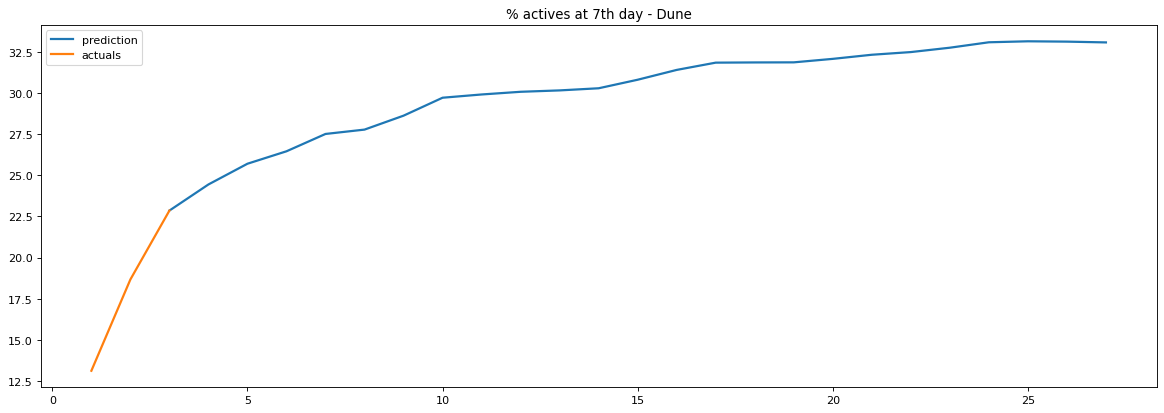

In [46]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_test['days_after_launch'], plot_test['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_actual['prediction_start_day'], plot_actual['pct_actives'],
                linewidth=2, label = 'actuals')
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Dune')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

# Result Validation

In [113]:
# Cumulative (#) and (%) of Viewing Subscribers
# Unique subscribers who have watched 2 minutes or more of a title

In [114]:
# validation_set = run_query('''
# SELECT * 
# FROM max_dev.workspace.pct_actives_cross_validation
# ''')

In [115]:
def mape_function(group):
    p = group['prediction']
    a = group['actuals']
    return (abs(p - a) / a).mean()

In [116]:
def mpe_function(group):
    p = group['prediction']
    a = group['actuals']
    return ((p - a) / a).mean()

In [117]:
mape_df = validation_set.groupby(['prediction_start_day', 'days_after_launch']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['prediction_start_day', 'days_after_launch', 'mape']
mape_df.pivot(index='prediction_start_day', columns='days_after_launch', values='mape')

days_after_launch,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0
prediction_start_day,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.073569,0.174838,0.229307,0.268176,0.309720,0.468404,0.531819,0.580247,1.026936,0.901942,0.929803,0.905377,0.891809,0.909783,0.915262,0.923926,0.905188,0.909043,0.922907,0.944116,0.848447,0.848569,0.847166,0.870645,0.887970,0.904977,0.915387
2,NaN,0.106426,0.179246,0.220984,0.263588,0.437416,0.487637,0.525181,1.152285,0.990099,1.016730,0.975800,0.967375,0.982400,0.994529,1.026576,1.002754,1.012927,1.028862,1.055506,0.940566,0.941746,0.951275,0.979818,0.996278,1.019680,1.004450
3,NaN,NaN,0.098502,0.159119,0.202660,0.357612,0.390790,0.425033,1.069912,0.895916,0.927788,0.886500,0.883246,0.898278,0.921304,0.945441,0.922611,0.931686,0.944370,0.965085,0.873545,0.871719,0.889280,0.920100,0.935998,0.952911,0.937374
4,NaN,NaN,NaN,0.096788,0.157666,0.313991,0.349814,0.386429,0.981497,0.827689,0.861341,0.822793,0.817572,0.833697,0.846507,0.870779,0.849522,0.858130,0.864378,0.887149,0.794103,0.790170,0.807725,0.832291,0.847099,0.866600,0.852341
5,NaN,NaN,NaN,NaN,0.096560,0.258821,0.293868,0.331645,0.850506,0.724643,0.754758,0.721786,0.715685,0.729457,0.741968,0.764655,0.747252,0.758829,0.766803,0.786621,0.695826,0.694734,0.711852,0.735231,0.748251,0.766098,0.747381
6,NaN,NaN,NaN,NaN,NaN,0.199670,0.240972,0.281141,0.724825,0.618885,0.647431,0.623229,0.610876,0.626795,0.644478,0.666993,0.657418,0.666898,0.677755,0.697429,0.598529,0.597760,0.615102,0.635163,0.646225,0.659513,0.640732
7,NaN,NaN,NaN,NaN,NaN,NaN,0.216221,0.261132,0.668299,0.575093,0.605014,0.582589,0.573013,0.587719,0.603866,0.627053,0.618919,0.626630,0.635981,0.651705,0.560423,0.559548,0.574562,0.594792,0.606368,0.618959,0.587503
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233246,0.628424,0.541815,0.569901,0.554081,0.546538,0.560713,0.577450,0.600693,0.590603,0.598819,0.607382,0.618146,0.535955,0.537219,0.552466,0.570770,0.583079,0.596696,0.556431
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589989,0.512389,0.543575,0.531879,0.525439,0.541188,10.934753,11.084339,11.193736,11.139582,11.164152,11.200255,11.171086,11.238905,11.233125,11.442347,11.454284,11.395481,11.355161


In [118]:
# Mape by Category
mape_df = validation_set[validation_set['days_after_launch'] == 26]\
        .groupby(['originals_type','content_category', 'prediction_start_day']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'mape']
mape_df.pivot(index=['originals_type', 'content_category'], columns='prediction_start_day', values='mape')

prediction_start_day                           1         2         3   \
originals_type         content_category                                 
acquired               livesports        0.098836  0.064452  0.053157   
                       movies            1.479203  1.818747  1.751522   
                       series            0.546086  0.460546  0.399289   
                       special           0.789844  0.590797  0.412258   
original               movies            0.521980  0.419872  0.357012   
                       series            0.509515  0.465221  0.399629   
                       special           0.569946  0.402067  0.363296   
originals_after_launch movies            0.964622  0.644668  0.439584   
                       series            0.824974  1.803737  1.711013   
                       special           0.452855  0.546550  0.202613   
popcorn_titles         movies            0.293320  0.143157  0.102839   

prediction_start_day                           4         5         6   \
originals_type         content_category                                 
acquired               livesports        0.043613  0.066946  0.051360   
                       movies            1.597287  1.404300  1.211023   
                       series            0.372198  0.334536  0.297174   
                       special           0.371578  0.303845  0.234255   
original               movies            0.293024  0.251438  0.213661   
                       series            0.366054  0.327874  0.286566   
                       special           0.280919  0.226308  0.206964   
originals_after_launch movies            0.504433  0.301269  0.317459   
                       series            1.663524  1.636744  1.693795   
                       special           0.252285  0.239038  0.212458   
popcorn_titles         movies            0.091814  0.080987  0.058601   

prediction_start_day                           7         8           9   \
originals_type         content_category                                   
acquired               livesports        0.038102  0.031155  247.546917   
                       movies            1.113386  1.057695    1.025285   
                       series            0.260460  0.234711    0.212440   
                       special           0.211380  0.252251    0.212415   
original               movies            0.203007  0.198635    0.185724   
                       series            0.261946  0.244536    0.224865   
                       special           0.190943  0.190798    0.182800   
originals_after_launch movies            0.335795  0.352800    0.347254   
                       series            1.944757  2.167019    2.206840   
                       special           0.200311  0.187132    0.171083   
popcorn_titles         movies            0.056345  0.057643    0.048146   

prediction_start_day                             10         11         12  \
originals_type         content_category                                     
acquired               livesports        276.801309  76.008841  60.352553   
                       movies              0.990697   0.945227   0.899886   
                       series              0.230670   0.208269   0.189365   
                       special             0.209677   0.194758   0.159524   
original               movies              0.172336   0.154440   0.140953   
                       series              0.206247   0.189787   0.176002   
                       special             0.164769   0.150246   0.135787   
originals_after_launch movies              0.246759   0.231752   0.143747   
                       series              2.199919   2.156417   2.064422   
                       special             0.155326   0.122185   0.103150   
popcorn_titles         movies              0.038137   0.036507   0.033656   

prediction_start_day                            13         14        15  \
originals_type         content_category        

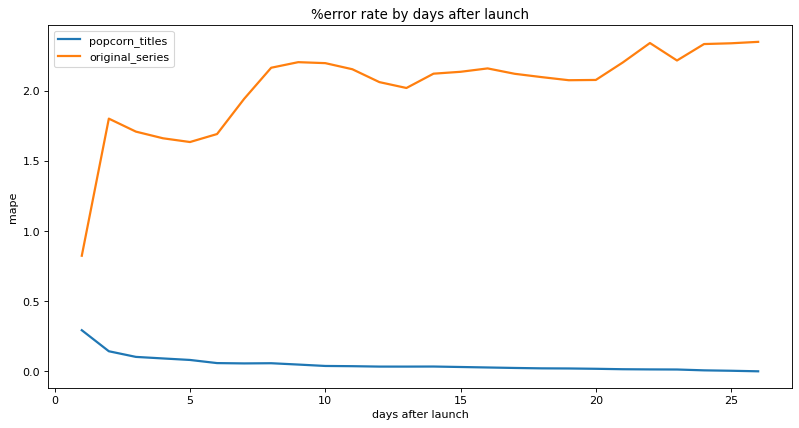

In [119]:
plot_df = mape_df[(mape_df['originals_type'] == 'popcorn_titles') 
                  | ((mape_df['originals_type'] == 'originals_after_launch') & (mape_df['content_category'] == 'series'))]

figure(figsize=(12, 6), dpi=80)
plt.plot(plot_df[(plot_df['originals_type'] == 'popcorn_titles')]['prediction_start_day'], 
         plot_df[(plot_df['originals_type'] == 'popcorn_titles')]['mape'],
         linewidth=2, label = 'popcorn_titles')
plt.plot(plot_df[((plot_df['originals_type'] == 'originals_after_launch') & (plot_df['content_category'] == 'series'))]['prediction_start_day'], 
         plot_df[((plot_df['originals_type'] == 'originals_after_launch') & (plot_df['content_category'] == 'series'))]['mape'], 
         linewidth=2, label = 'original_series')
plt.title('%error rate by days after launch')
plt.xlabel('days after launch')
plt.ylabel('mape')
plt.legend()
plt.show()

In [120]:
plot_df = validation_set.groupby(['title_name', 'available_date','originals_type', 'prediction_start_day']).apply(mpe_function)
plot_df = pd.DataFrame(plot_df).reset_index()
plot_df.columns = ['title_name', 'available_date', 'originals_type', 'prediction_start_day', 'mape']
plot_df = plot_df[plot_df['prediction_start_day'] == 7]
plot_df['available_date'] = pd.to_datetime(plot_df['available_date'], format='%Y-%m-%d')

In [121]:
plot_df.loc[plot_df['originals_type'] == 'originals_after_launch', 'color'] = 1
plot_df.loc[plot_df['originals_type'] == 'popcorn_titles', 'color'] = 2

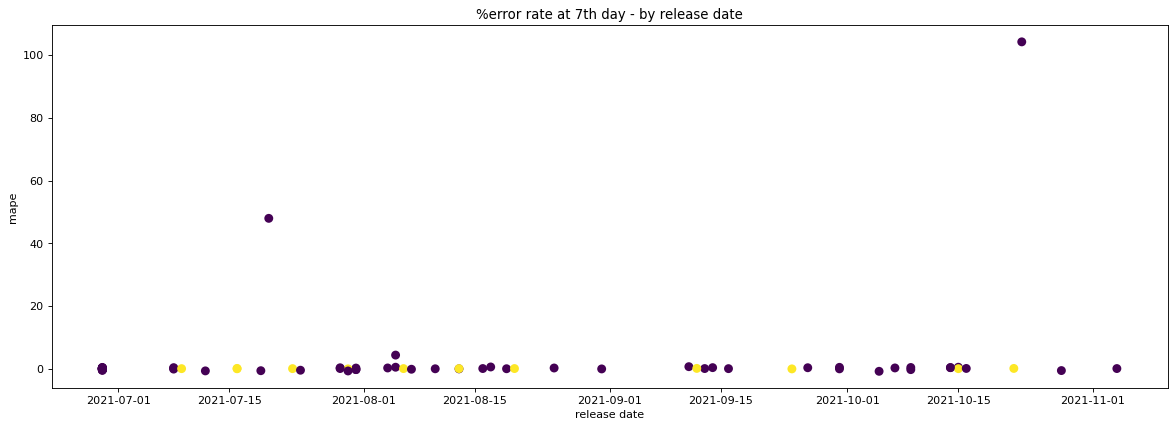

In [122]:
figure(figsize=(18, 6), dpi=80)
plt.scatter(plot_df['available_date'], plot_df['mape'], c = plot_df['color'],
                linewidth=2)
plt.title('%error rate at 7th day - by release date')
plt.xlabel('release date')
plt.ylabel('mape')
# plt.legend()
plt.show()

In [123]:
validation_set['pct_error'] = (validation_set['prediction']-validation_set['actuals'])/validation_set['actuals']
validation_set['multiplier'] = (1/(1+validation_set['pct_error']))

In [124]:
validation_set[(validation_set['pct_error'] > 1000)].content_category.unique()

array(['movies', 'livesports'], dtype=object)

In [ ]:
data = validation_set[(validation_set['originals_type'] == 'originals_after_launch') 
                      & (validation_set['content_category'] == 'series') 
                      & (validation_set['days_after_launch'] == 26)
                      & (validation_set['prediction_start_day'] == 5)
                     &(validation_set['pct_error'].notnull())]#['pct_error']

In [ ]:
def ci_calculation(data, ci_level = 0.95, field = 'multiplier'):
    data = data[data[field].notnull()][field]
    lower, upper = st.t.interval(alpha=ci_level, 
                         df=len(data)-1, 
                         loc=np.mean(data), 
                         scale=st.sem(data)) 
    return lower, upper

In [ ]:
ci_df = validation_set.groupby(['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch']).apply(ci_calculation)
ci_df = pd.DataFrame(ci_df).reset_index()
ci_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch', 'multiplier']
ci_df['lower_index'], ci_df['upper_index'] = zip(*ci_df['multiplier'])
ci_df['lower_index'] = ci_df['lower_index'].fillna(1)
ci_df['upper_index'] = ci_df['upper_index'].fillna(1)
ci_df.drop(['multiplier'], axis = 1, inplace = True)

In [ ]:
validation_set = pd.merge(validation_set, ci_df, on = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch'],
                         how = 'left')
# validation_set['upper_bound'] = validation_set['prediction']/(1+validation_set['lower_index'])
# validation_set['lower_bound'] = validation_set['prediction']/(1+validation_set['upper_index'])
validation_set['upper_bound'] = validation_set['prediction']*validation_set['upper_index']
validation_set['lower_bound'] = validation_set['prediction']*validation_set['lower_index']

In [176]:
plot_df = validation_set[(validation_set['title_name'] == 'Dune')
                        &(validation_set['prediction_start_day'] == 7)]

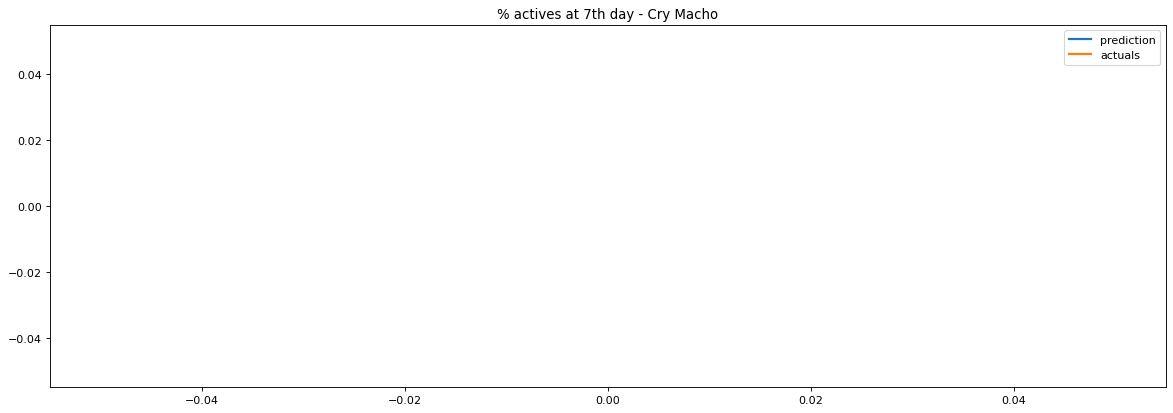

In [177]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Cry Macho')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [127]:
plot_df = validation_set[(validation_set['title_name'] == 'Malignant')
                        &(validation_set['prediction_start_day'] == 7)]

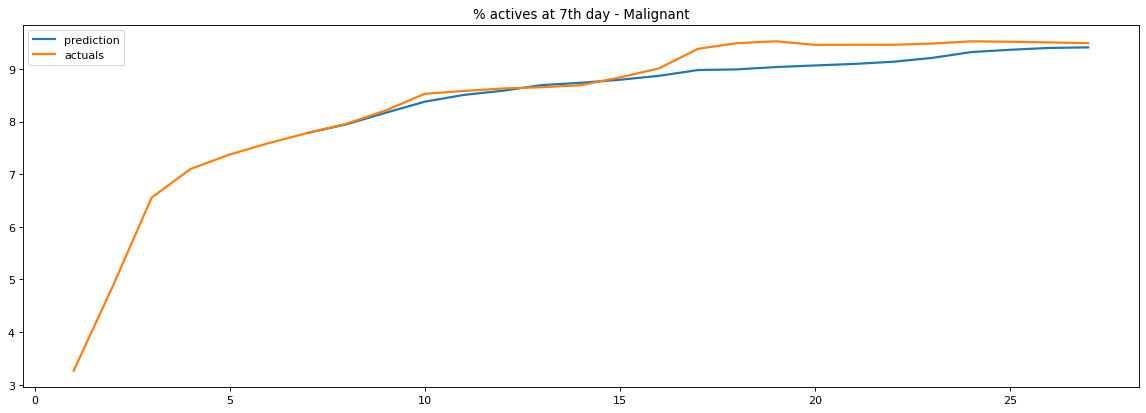

In [129]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Malignant')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [130]:
plot_df = validation_set[(validation_set['title_name'] == 'The Undoing')
                        &(validation_set['prediction_start_day'] == 7)]

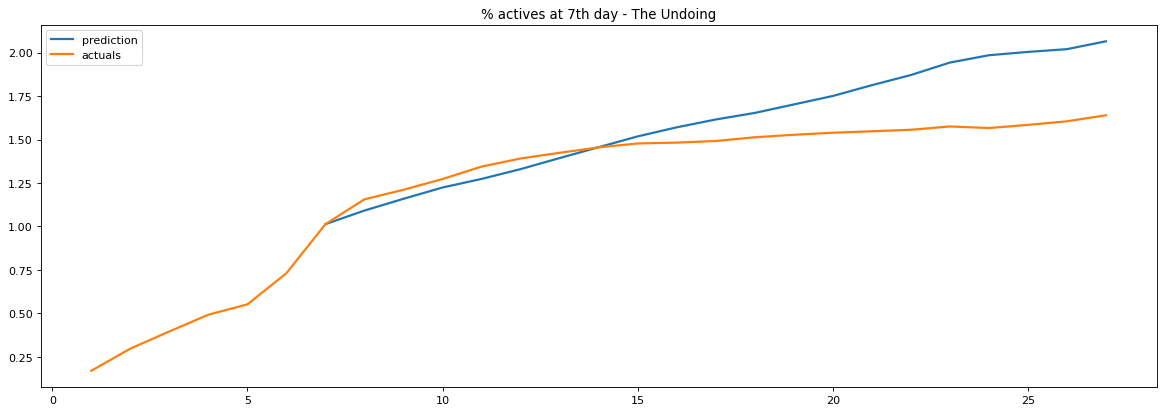

In [131]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
plt.title('% actives at 7th day - The Undoing')
# plt.ylim(0, 10)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [132]:
plot_df = validation_set[(validation_set['title_name']=='Love Life')
                        &(validation_set['prediction_start_day'] == 7)]

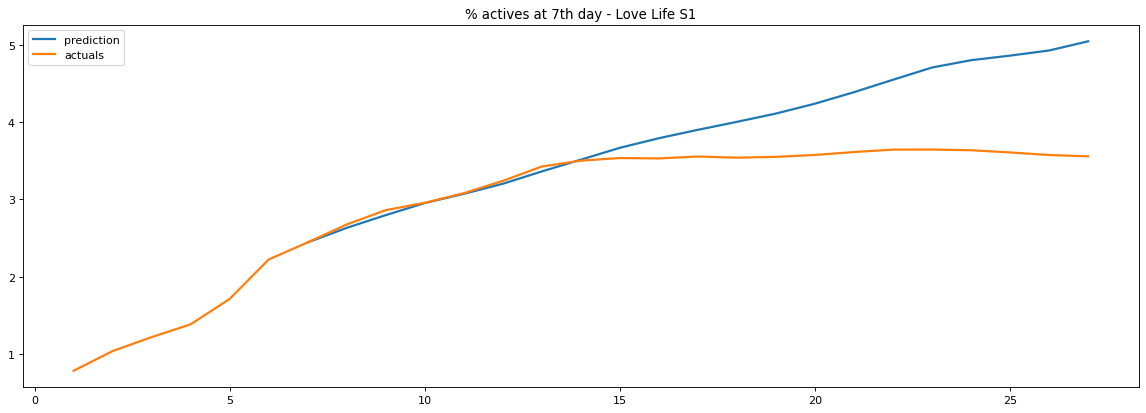

In [133]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Love Life S1')
# plt.ylim(0, 20)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [134]:
plot_df = validation_set[(validation_set['title_name']=='Mare of Easttown')
                        &(validation_set['prediction_start_day'] == 7)]

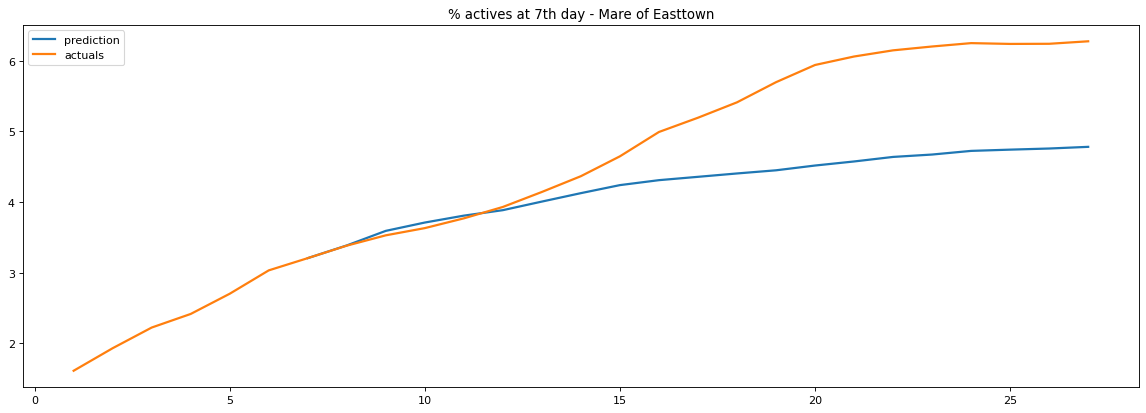

In [135]:
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                linewidth=2, label = 'prediction')
plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                linewidth=2, label = 'actuals')
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Mare of Easttown')
# plt.ylim(0, 20)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

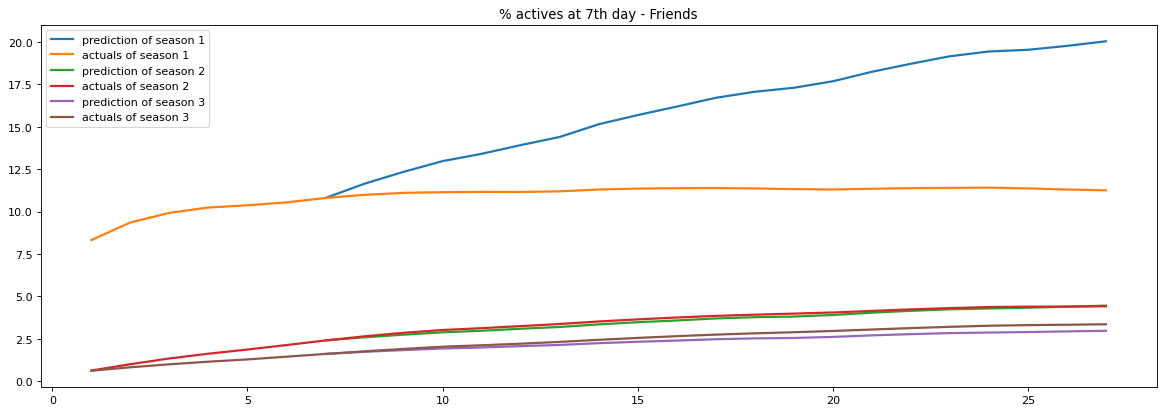

In [136]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title_name'] == 'Friends')
                            &(validation_set['match_id'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Friends')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

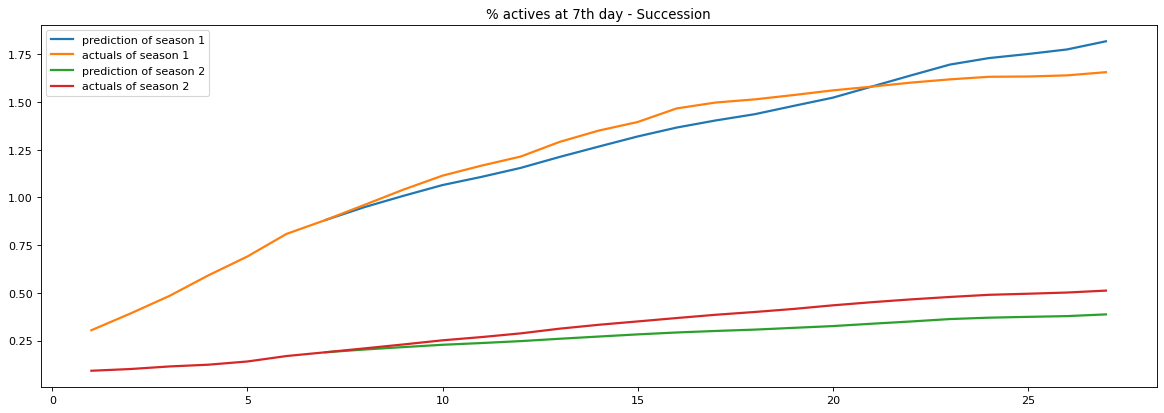

In [172]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 3, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title_name'] == 'Succession')
                            &(validation_set['match_id'].str[-1::1] == str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Succession')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

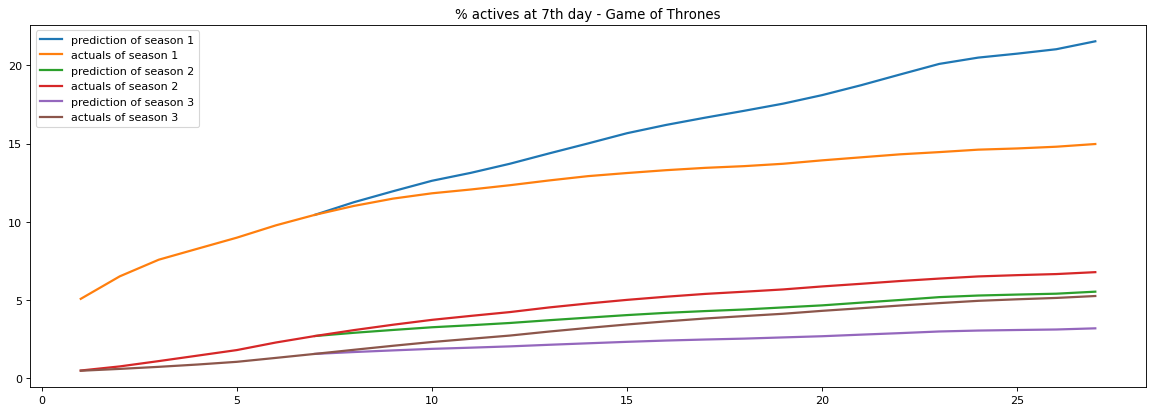

In [170]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title_name'] == 'Game of Thrones')
                            &(validation_set['match_id'].str[-2::1] == '-'+str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Game of Thrones')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

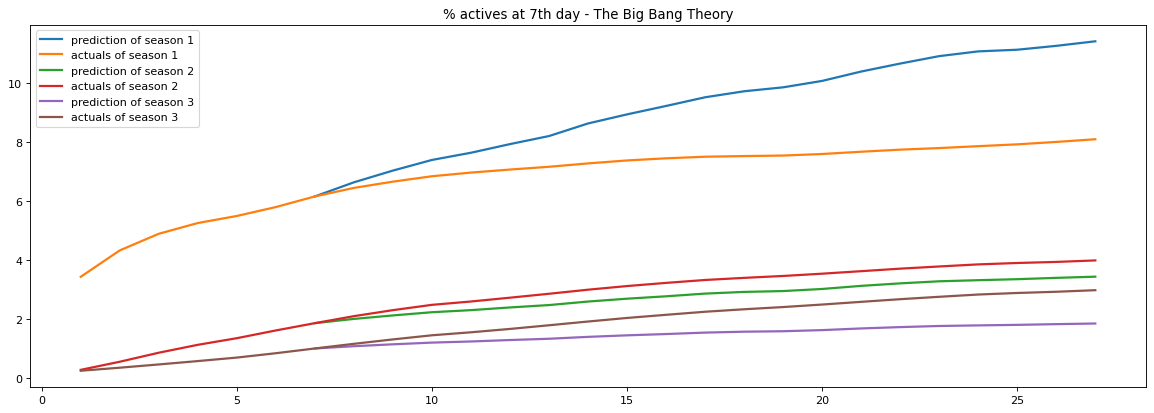

In [165]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title_name'] == 'The Big Bang Theory')
                            &(validation_set['match_id'].str[-2::1] == '-'+str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - The Big Bang Theory')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

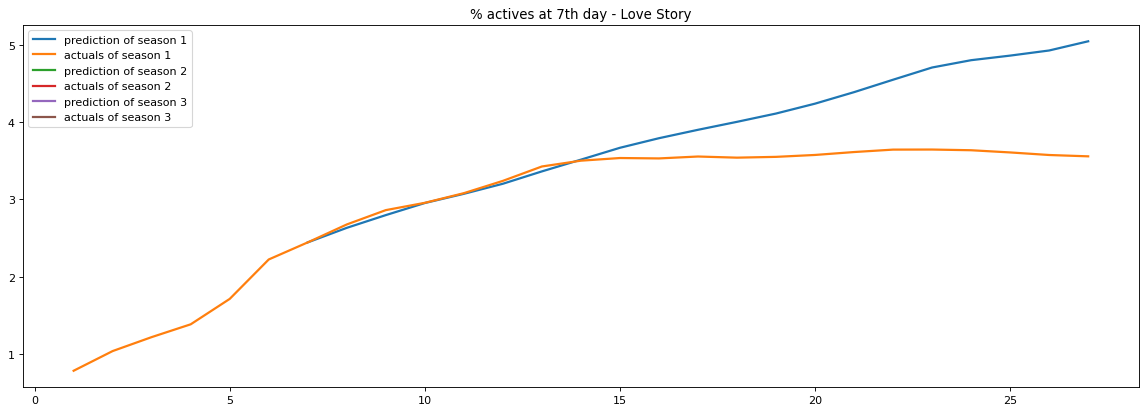

In [167]:
figure(figsize=(18, 6), dpi=80)
for i in range(1, 4, 1):
    plot_df = validation_set[(validation_set['prediction_start_day'] == 7)
                            &(validation_set['title_name'] == 'Love Life')
                            &(validation_set['match_id'].str[-2::1] == '-'+str(i))]\
              .sort_values(by = ['days_after_launch'])
    plt.plot(plot_df['days_after_launch'], plot_df['prediction'],
                    linewidth=2, label = 'prediction of season ' + str(i))
    plt.plot(plot_df['days_after_launch'], plot_df['actuals'],
                    linewidth=2, label = 'actuals of season ' + str(i))
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Love Story')
# plt.ylim(10, 25)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

# Checks

In [145]:
pct_actives[(pct_actives['days_on_hbo_max'] == 27)].sort_values(by = ['pct_actives'], ascending = False)\
[['title_name', 'available_date', 'actives', 'pct_actives']].head(10)

,title_name,available_date,actives,pct_actives
59972,Space Jam: A New Legacy,2021-08-20,2353737,40.499472
80988,Godzilla vs. Kong,2021-07-16,1718557,31.983531
65886,Mortal Kombat,2021-08-06,1601557,28.263412
51870,Wonder Woman 1984,2021-06-29,1041971,23.396861
84210,The Suicide Squad,2021-09-12,1300661,22.745099
84211,The Suicide Squad,2021-09-12,1182979,20.687154
64148,The Conjuring: The Devil Made Me Do It,2021-07-09,997791,19.122016
50528,Friends: The Reunion,2021-06-29,831837,18.678422
51891,Zack Snyder's Justice League,2021-06-29,766873,17.219693
64152,Tom & Jerry,2021-07-09,883159,16.925168


In [269]:
pct_actives[(pct_actives['end_date'] == '2021-10-11')
           &(pct_actives['start_date'] == '2021-10-09')].sort_values(by = ['actives'])

,match_id,title_name,prediction_start_day,available_date,actives,start_date,end_date,actives_base,pct_actives,id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg,originals_type,real_date
64540,GXwzPRAf5ncPDwgEAAAcY,Rose Matafeo: Horndog,2,2021-10-09,13,2021-10-09,2021-10-11,2748308,0.000473,Rose Matafeo: Horndog,1-GXwzPRAf5ncPDwgEAAAcY,-1.0,2020-08-20 07:01:00.000,1.0,original,special,1.0,0.0,1.0,4.0,0.955000,2020.0,0.00000,"avalon television limited, warner media direct...",comedy|original|stand-up comedy,comedy,comedy|original|stand-up comedy,originals_after_launch,2021-10-11
64534,GYOykUABM3sPDwgEAAAe6-1,Back On the Record with Bob Costas,2,2021-10-09,78,2021-10-09,2021-10-11,2748308,0.002838,Back On the Record with Bob Costas S1,1-GYOykUABM3sPDwgEAAAe6-1,1.0,2021-07-31 06:00:00.000,1.0,original,series,0.0,1.0,1.0,6.0,2.866806,2021.0,0.00274,hbo original,sport,news/talk | sports | documentary | originals|s...,documentary | sport|documentary | original | s...,originals_after_launch,2021-10-11
64539,GYC1puQhu1cLCwgEAAAA0,Persona: The Dark Truth Behind Personality Tests,2,2021-10-09,826,2021-10-09,2021-10-11,2748308,0.030055,Persona: The Dark Truth Behind Personality Tests,1-GYC1puQhu1cLCwgEAAAA0,-1.0,2021-03-04 08:01:00.000,1.0,original,movies,1.0,0.0,1.0,4.0,1.417500,2021.0,0.00000,"go there productions, warner media direct, llc",documentary,documentary,documentary,originals_after_launch,2021-10-11


In [146]:
# Daily Actives by title
title_actives_us = run_query('''
with max_release_date_base as (

        select
          distinct
          rad.title_id,
          case
            when rad.season_number is null
                then title_name
            else concat(rad.series_title_long,' S',rad.season_number)
          end as title,
          'Seasons and Movies' as title_level,
          first_value(raod.first_offered_date) over (partition by title order by raod.first_offered_date asc) as first_release_date,
          case
            when aod.offering_start_date <='2020-05-27 07:00:00' THEN '2020-05-27 07:00:00'
            else aod.offering_start_date
          end as offering_start_date,
          aod.offering_end_date
          , case when content_category = 'series'
            then ifnull(season_number, 1)
            else season_number
                end as season_number_adj
        , coalesce(concat(rad.series_id, '-', season_number_adj), rad.viewable_id) as match_id
        from
          max_prod.catalog.reporting_asset_dim rad
        join max_prod.catalog.asset_offering_dim aod
            on rad.viewable_id = aod.viewable_id
                and aod.offering_end_date>='2020-05-27 07:00:00'
                AND aod.brand = 'HBO MAX'
        join max_prod.catalog.reporting_asset_offering_dim raod
          on aod.viewable_id = raod.viewable_id
            AND aod.channel = raod.channel
            AND aod.brand = raod.brand
            AND raod.territory = aod.territory -- leave as HBO MAX domestic because no MUS?
        where
          raod.first_offered_date is not null
          and rad.asset_type = 'FEATURE'
          and offering_start_date<=sysdate()
          and aod.territory='HBO MAX DOMESTIC'
      ),
      second as (
        SELECT
           s1.title_id,
           s1.match_id,
           s1.title,
           s1.title_level,
           s1.first_release_date,
           s1.offering_start_date,
           MIN(t1.offering_end_date) AS offering_end_date
        FROM max_release_date_base s1
          INNER JOIN max_release_date_base t1 ON s1.offering_start_date <= t1.offering_end_date and s1.title_id=t1.title_id and s1.title=t1.title and s1.title_level=t1.title_level
            AND NOT EXISTS(SELECT * FROM max_release_date_base t2
                           WHERE t1.offering_end_date >= t2.offering_start_date AND t1.offering_end_date < t2.offering_end_date
                            and t1.title_id=t2.title_id and t1.title=t2.title
                          )
        WHERE NOT EXISTS(SELECT * FROM max_release_date_base s2
                           WHERE s1.offering_start_date > s2.offering_start_date AND s1.offering_start_date <= s2.offering_end_date
                            and s1.title_id=s2.title_id and s1.title=s2.title
                          )
        GROUP BY 1,2,3,4,5, 6
        order by 1,2,3,4,5, 6
      ),
      third as
        (SELECT
        title_id,
        title,
        title_level,
        match_id,
        max(offering_end_date) as end_date
        from second
        group by 1,2,3,4),
      fourth as
        (SELECT
         title_id,
        title,
        title_level,
        match_id,
        case when end_date>=sysdate() then FALSE
        else TRUE end as is_inactive
        from third),
       fifth as
         (SELECT
         title,
         title_id,
         title_level,
         max(days_on_hbo_max) as total_days
        from content_intelligence.new_title_release_days_on_platform
        group by 1,2,3)

     SELECT c.match_id, a.title, a.first_release_date, a.DAILY_VIEWING_SUBS, a.CUMULATIVE_VIEWING_SUBS, 
             a.days_on_hbo_max, a.title_id
       FROM content_intelligence.new_title_release_days_on_platform a
        inner join fifth b on initcap(a.title)=initcap(b.title) and a.title_id=b.title_id and a.title_level=b.title_level
        inner join fourth c on initcap(a.title)=initcap(c.title) and a.title_id=c.title_id and a.title_level=c.title_level
      where (days_on_hbo_max between 1 and 28)
''')

In [147]:
## Total Active Base
daily_total_views_us = run_query('''
select *, datediff(day, start_date, end_date)+1 as days_after_launch
from max_dev.workspace.actives_base_first_view
where days_after_launch<= 28
order by start_date
''')

In [148]:
title_actives_us.drop_duplicates(inplace = True)

In [149]:
title_actives_us['available_date'] = title_actives_us['first_release_date'].astype(str).str[0:10:1]

In [150]:
pct_actives_us = pd.merge(title_actives_us[['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date', 'cumulative_viewing_subs']], 
                      daily_total_views_us[['start_date', 'end_date', 'cumulative_viewing_subs_denom', 'days_after_launch']],
                      left_on = ['available_date', 'days_on_hbo_max'], right_on = ['start_date', 'days_after_launch'],
                      how = 'left')

In [151]:
pct_actives_us['pct_actives'] = pct_actives_us['cumulative_viewing_subs']/pct_actives_us['cumulative_viewing_subs_denom']*100

In [152]:
pct_actives.rename(columns = {'prediction_start_day':'days_on_hbo_max'}, inplace = True)

In [153]:
pct_actives_us.columns

Index(['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date',
       'cumulative_viewing_subs', 'start_date', 'end_date',
       'cumulative_viewing_subs_denom', 'days_after_launch', 'pct_actives'],
      dtype='object')

In [154]:
pct_actives_us.rename(columns = {'cumulative_viewing_subs':'actives_us', 
                                'pct_actives': 'pct_actives_us'}, inplace = True)

In [163]:
pct_actives_us.head()

,match_id,title,title_id,days_on_hbo_max,available_date,actives_us,start_date,end_date,cumulative_viewing_subs_denom,days_after_launch,pct_actives_us
0,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,1,2020-11-01,169,2020-11-01,2020-11-01,2152394.0,1.0,0.007852
1,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,2,2020-11-01,300,2020-11-01,2020-11-02,3017388.0,2.0,0.009942
2,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,3,2020-11-01,384,2020-11-01,2020-11-03,3424375.0,3.0,0.011214
3,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,4,2020-11-01,493,2020-11-01,2020-11-04,3767118.0,4.0,0.013087
4,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,5,2020-11-01,595,2020-11-01,2020-11-05,4035813.0,5.0,0.014743


In [164]:
pct_actives_us[(pct_actives_us['days_on_hbo_max'] == 27)].sort_values(by = ['pct_actives_us'], ascending = False)\
[['title', 'available_date', 'actives_us', 'pct_actives_us']].head(10)

,title,available_date,actives_us,pct_actives_us
52604,Wonder Woman 1984,2020-12-25,10699532,69.269577
125931,Godzilla vs. Kong,2021-03-31,13970339,66.914022
141308,Mortal Kombat,2021-04-23,13225694,63.511967
32509,The Suicide Squad,2021-08-05,13023405,58.860427
48506,Zack Snyder's Justice League,2021-03-18,10108386,51.623607
43257,Dune,2021-10-21,11329767,51.541667
153278,The Little Things,2021-01-29,7843741,50.370483
97633,Space Jam: A New Legacy,2021-07-16,10382474,47.235064
54668,Friends: The Reunion,2021-05-27,8650115,39.265040
21040,Tom & Jerry,2021-02-26,6373281,37.907919


In [155]:
pct_actives_all = pd.merge(pct_actives_us[pct_actives_us['days_on_hbo_max'] == 28][['match_id', 'actives_us', 'pct_actives_us']], 
                           pct_actives[pct_actives['days_on_hbo_max'] == 26], on = ['match_id'])

In [156]:
pct_actives_all.head()

,match_id,actives_us,pct_actives_us,title_name,days_on_hbo_max,available_date,actives,start_date,end_date,actives_base,pct_actives,id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg,originals_type,real_date
0,GXuEzeAABO8PCwgEAAAw5,118826,0.567945,Dead Silence,26,2021-06-29,6192,2021-06-29,2021-07-25,4329125,0.143031,Dead Silence,1-GXuEzeAABO8PCwgEAAAw5,-1.0,2021-04-01 10:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,4.0,1.415833,2007.0,14.054795,"universal studios pay television, inc.",horror|thriller,suspense | horror,horror | suspense,acquired,2021-07-25
1,GXJviOAyk84G6gAEAAAIV,7565,0.204734,Deadwood: The Movie,26,2021-06-29,6275,2021-06-29,2021-07-25,4329125,0.144948,Deadwood: The Movie,0-GXJviOAyk84G6gAEAAAIV,-1.0,2019-06-01 00:00:00.000,0.0,original,movies,1.0,0.0,1.0,6.0,1.544111,2019.0,0.002740,hbo original,drama,drama | originals | action,action| drama| originals,original,2021-07-25
2,GXmF6WQi3Vp4_wwEAAClz,16459,0.445435,Deep Blue Sea,26,2021-06-29,8794,2021-06-29,2021-07-25,4329125,0.203136,Deep Blue Sea,1-GXmF6WQi3Vp4_wwEAAClz,-1.0,2020-05-27 07:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,3.0,1.603611,1999.0,21.000000,"warner bros. inc., warner media direct, llc",action|horror|thriller|sci-fi,action | fantasy & sci-fi | suspense | horror,action|horror|sci-fi|thriller,acquired,2021-07-25
3,GXjr8RwEaRcPDwwEAAAfh,4733,0.128091,Deliverance,26,2021-06-29,3928,2021-06-29,2021-07-25,4329125,0.090734,Deliverance,1-GXjr8RwEaRcPDwwEAAAfh,-1.0,2020-05-27 07:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,3.0,1.805556,1972.0,48.000000,"warner media direct, llc",adventure|drama|action|adaptation|nature|thriller,drama | action | suspense | documentary,action|adaptation|adventure|drama|nature|thriller,acquired,2021-07-25
4,GX5NtMQkTXJ2ywgEAAACi,121495,0.895030,Demolition Man,26,2021-08-17,27256,2021-08-17,2021-09-12,5629065,0.484201,Demolition Man,1-GX5NtMQkTXJ2ywgEAAACi,-1.0,2020-12-01 08:01:00.000,1.0,acquired,movies,1.0,0.0,0.0,2.0,1.847917,1993.0,27.000000,"warner bros. inc., warner media direct, llc",action|comedy|adventure|sci-fi|thriller,comedy | action | fantasy & sci-fi | suspense,action|adventure|comedy|sci-fi|thriller,acquired,2021-09-12


In [157]:
pct_actives_all['pct_actives'] = pct_actives_all['pct_actives'].fillna(0)
pct_actives_all['pct_actives_us'] = pct_actives_all['pct_actives_us'].fillna(0)

In [158]:
pct_actives_all.sort_values(['pct_actives_us'], inplace = True)

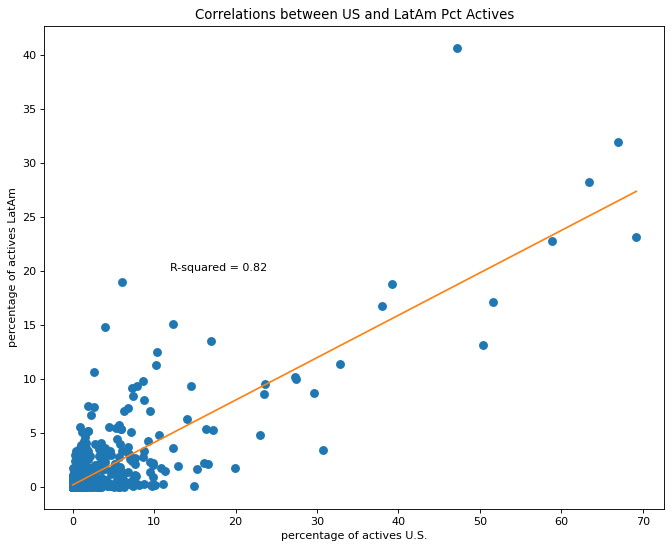

In [159]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(pct_actives_all['pct_actives_us'], pct_actives_all['pct_actives'],
                linewidth=2)
plt.title('Correlations between US and LatAm Pct Actives')

linreg = st.linregress(pct_actives_all['pct_actives_us'], pct_actives_all['pct_actives'])
plt.plot(pct_actives_all['pct_actives_us'], 
         np.poly1d(np.polyfit(pct_actives_all['pct_actives_us'], 
                              pct_actives_all['pct_actives'], 1))\
         (pct_actives_all['pct_actives_us']),
        color = 'tab:orange')

plt.text(12, 20, 'R-squared = %0.2f' % linreg.rvalue)


plt.xlabel('percentage of actives U.S.')
plt.ylabel('percentage of actives LatAm')
plt.show()

In [22]:
run_query('''
select *
from max_dev.workspace.latam_metrics_base
limit 10
''')

,start_date,end_date,days_on_hbo_max,actives_base,total_hours_viewed_base,record_count_base,first_viewing_accounts_base
0,2021-11-02,2021-11-29,27,5849633,138350754,308505897,642792
1,2021-11-01,2021-11-29,28,5894686,143715425,320272944,669786
2,2021-11-03,2021-11-29,26,5788947,131975884,294995473,602638
3,2021-11-04,2021-11-29,25,5720827,126364045,282533629,563309
4,2021-11-06,2021-11-29,23,5634434,116996903,260969272,521276
5,2021-11-07,2021-11-29,22,5576813,111788519,249682598,494756
6,2021-11-05,2021-11-29,24,5678635,121582691,271471548,542286
7,2021-11-09,2021-11-29,20,5457551,100815423,225658703,443462
8,2021-11-08,2021-11-29,21,5504002,105651057,236921498,464062
9,2021-11-10,2021-11-29,19,5410429,96030217,214440869,422604
